In [3]:
# imports and load
import os, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, roc_curve, classification_report)

# Path to your cleaned dataset
df_e = pd.read_csv("C:/Users/cebho/Downloads/Cleaned_Preprocessed_Dataset_Week1 - Cleaned_Preprocessed_Dataset_Week1.csv.csv")
df_e.head()

,Learner SignUp DateTime,Opportunity Id,Opportunity Name,Opportunity Category,Opportunity End Date,First Name,Date of Birth,Gender,Country,Institution Name,...,Age,Opportunity_Duration_Days,Signup_Season,Tenure_Days,Application_Lag_Days,Region,Apply_Year,Apply_Month,Signup_Timing,Age_Group
0,2023-06-14 12:30:35,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Faria,2001-12-01 0:00:00,Female,Pakistan,Nwihs,...,23,841,Summer,793,0,Asia,2023,6,Late Joiner,23-27 (Graduate)
1,2023-01-05 5:29:16,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Poojitha,2000-08-16 0:00:00,Female,India,SAINT LOUIS,...,24,841,Winter,953,0,Asia,2023,1,Late Joiner,23-27 (Graduate)
2,2023-09-04 20:35:08,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Emmanuel,2002-01-27 0:00:00,Male,United States,Illinois Institute of Technology,...,23,841,Fall,710,710,North America,2025,8,Late Joiner,23-27 (Graduate)
3,2023-08-29 5:20:03,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Amrutha Varshini,1999-01-11 0:00:00,Female,United States,Saint Louis University,...,26,841,Summer,717,12,North America,2023,9,Late Joiner,23-27 (Graduate)
4,2023-06-01 15:26:36,00000000-0GN2-A0AY-7XK8-C5FZPP,Career Essentials: Getting Started with Your P...,Course,2024-06-29 18:52:39,Vinay Varshith,2000-04-19 0:00:00,Male,United States,Saint Louis University,...,25,841,Summer,805,0,North America,2023,6,Late Joiner,23-27 (Graduate)


In [4]:
# helper to find columns with flexible names
import re
def norm(s): 
    return re.sub(r'[^0-9a-z]', '', str(s).lower())

norm_to_col = {norm(c): c for c in df_e.columns}
def find_col(variants):
    for v in variants:
        k = norm(v)
        if k in norm_to_col:
            return norm_to_col[k]
    return None

# Example usage
print("Detected columns (examples):")
print("status description ->", find_col(["Status Description","statusdescription","status"]))
print("age ->", find_col(["Age","age","dateofbirth","dob"]))


Detected columns (examples):
status description -> Status Description
age -> Age


In [5]:
# create churn target from status fields (1 = churn/drop-off, 0 = completed)
status_desc_col = find_col(["Status Description", "statusdescription"])
status_group_col = find_col(["Status_Group", "Status Group", "statusgroup"])
status_cols = [c for c in [status_desc_col, status_group_col] if c is not None]

print("Status columns found:", status_cols)

def map_churn(text):
    if pd.isna(text): 
        return None
    t = str(text).lower()
    if any(k in t for k in ["drop","dropped","withdrawn","withdraw","rejected","fail","abandoned"]):
        return 1
    if any(k in t for k in ["complete","completed","closed","accepted","success"]):
        return 0
    # ambiguous statuses (applied, in progress) -> mark unknown
    return None

# Try to map using status description first, fallback to status_group
df_e['churn'] = None
if status_desc_col is not None:
    df_e['churn'] = df_e[status_desc_col].apply(map_churn)

# If too many unknowns, try status_group
if df_e['churn'].isna().mean() > 0.5 and status_group_col is not None:
    df_e['churn'] = df_e[status_group_col].apply(map_churn)

print("Churn distribution (including NaN):")
print(df_e['churn'].value_counts(dropna=False))

# Show a small sample - only include columns that exist
sample_cols = ['churn']
if status_desc_col is not None:
    sample_cols.append(status_desc_col)
if status_group_col is not None:
    sample_cols.append(status_group_col)
    
df_e[sample_cols].head(10)

Status columns found: ['Status Description']
Churn distribution (including NaN):
churn
NaN    4286
1.0    4272
Name: count, dtype: int64


,churn,Status Description
0,NaN,Started
1,NaN,Started
2,NaN,Started
3,NaN,Team Allocated
4,NaN,Started
5,NaN,Waitlisted
6,1.0,Withdraw
7,NaN,Team Allocated
8,NaN,Started
9,NaN,Team Allocated


In [6]:
# Adjusted churn mapping: treat "started", "team allocated", "waitlisted" as NOT churn (0)

def map_churn(text):
    if pd.isna(text): 
        return None
    t = str(text).lower()
    
    # Churn / drop-off
    if any(k in t for k in ["drop","dropped","withdrawn","withdraw","rejected","fail","abandoned"]):
        return 1
    
    # Non-churn (active or completed)
    if any(k in t for k in ["complete","completed","closed","accepted","success",
                            "started","team allocated","waitlisted"]):
        return 0
    
    # Ambiguous = unknown
    return None

# Try to map using status description first
df_e['churn'] = None
if status_desc_col is not None:
    df_e['churn'] = df_e[status_desc_col].apply(map_churn)

# If too many unknowns, try status_group as fallback
if df_e['churn'].isna().mean() > 0.5 and status_group_col is not None:
    df_e['churn'] = df_e[status_group_col].apply(map_churn)

print("Churn distribution (including NaN):")
print(df_e['churn'].value_counts(dropna=False))



Churn distribution (including NaN):
churn
1.0    4272
0.0    4152
NaN     134
Name: count, dtype: int64


In [7]:
# filter for rows with known churn label
df_model = df_e[~df_e['churn'].isna()].copy()
df_model['churn'] = df_model['churn'].astype(int)

print("Rows with labels:", df_model.shape[0])
print("Class distribution:\n", df_model['churn'].value_counts())

# If one class only, stop and inspect status labels
if df_model['churn'].nunique() < 2:
    raise RuntimeError("Only one class present in churn labels. Cannot train classifier. Inspect status labels or create proxy labels.")


Rows with labels: 8424
Class distribution:
 churn
1    4272
0    4152
Name: count, dtype: int64


In [8]:
# prepare candidate features and detect availability
candidates = ['Age','Application_Lag_Days','Opportunity_Duration_Days','Tenure_Days',
              'Gender','Region','Opportunity Category','Institution_Type','Apply_Year','Apply_Month']

available = []
for c in candidates:
    col = find_col([c, c.replace(" ",""), c.lower()])
    if col and col in df_model.columns:
        available.append(col)

print("Available features found:", available)

# Choose final features (ensure mix of numeric + categorical)
# Use as many as available but drop ones with too many missing
features = available.copy()
# Remove features with >50% missing
features = [f for f in features if df_model[f].notna().mean() > 0.5]
print("Selected features for modeling:", features)


Available features found: ['Age', 'Application_Lag_Days', 'Opportunity_Duration_Days', 'Tenure_Days', 'Gender', 'Region', 'Opportunity Category', 'Apply_Year', 'Apply_Month']
Selected features for modeling: ['Age', 'Application_Lag_Days', 'Opportunity_Duration_Days', 'Tenure_Days', 'Gender', 'Region', 'Opportunity Category', 'Apply_Year', 'Apply_Month']


In [9]:
# split and build preprocessing pipeline
X = df_model[features]
y = df_model['churn']

# Quick imputation plan: numeric -> median, categorical -> constant then one-hot
numeric_feats = [c for c in features if pd.api.types.is_numeric_dtype(df_model[c])]
cat_feats = [c for c in features if c not in numeric_feats]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Changed 'sparse' to 'sparse_output'
])
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_feats),
    ('cat', categorical_transformer, cat_feats)
], remainder='drop')

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
print("Train/test sizes:", X_train.shape, X_test.shape)


Train/test sizes: (6318, 9) (2106, 9)


In [10]:
# fit Logistic Regression and Random Forest
log_pipe = Pipeline(steps=[('preproc', preprocessor), ('clf', LogisticRegression(max_iter=1000, random_state=42))])
rf_pipe = Pipeline(steps=[('preproc', preprocessor), ('clf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])

# Fit
log_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)


Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age',
                                                   'Application_Lag_Days',
                                                   'Opportunity_Duration_Days',
                                                   'Tenure_Days', 'Apply_Year',
                                                   'Apply_Month']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Region',
                                                   'Opportunity Category'])])),
                ('clf',
                 RandomForestClassifier(n_estimators=200, n_jobs=-1,
                                        random_state=42))])


LogisticRegression classification report:
               precision    recall  f1-score   support

           0       0.98      0.83      0.90      1038
           1       0.85      0.98      0.91      1068

    accuracy                           0.91      2106
   macro avg       0.92      0.90      0.91      2106
weighted avg       0.92      0.91      0.91      2106

LogisticRegression metrics: {'accuracy': 0.905982905982906, 'precision': 0.8542345276872965, 'recall': 0.9822097378277154, 'f1': 0.9137630662020906, 'roc_auc': np.float64(0.940726187641171)}


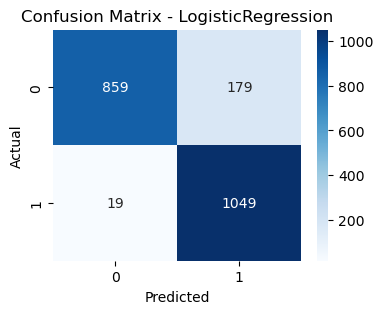

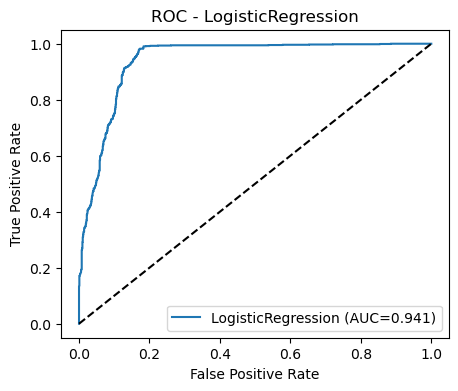


RandomForest classification report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90      1038
           1       0.88      0.93      0.90      1068

    accuracy                           0.90      2106
   macro avg       0.90      0.90      0.90      2106
weighted avg       0.90      0.90      0.90      2106

RandomForest metrics: {'accuracy': 0.9007597340930674, 'precision': 0.8845120859444942, 'recall': 0.9250936329588015, 'f1': 0.9043478260869565, 'roc_auc': np.float64(0.9620939865630389)}


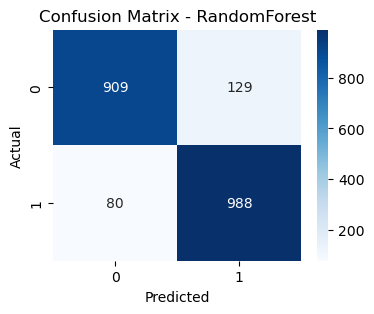

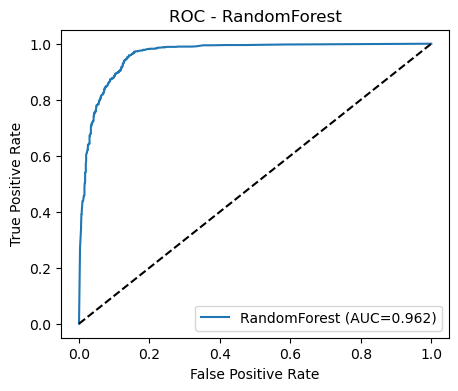

In [11]:
# evaluation helper
def evaluate_model(pipe, X_test, y_test, name="model"):
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:,1] if hasattr(pipe.named_steps['clf'], "predict_proba") else None
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_prob) if y_prob is not None and len(np.unique(y_test))>1 else None
    }
    print(f"\n{name} classification report:\n", classification_report(y_test, y_pred, zero_division=0))
    print(f"{name} metrics:", metrics)
    # confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()
    # ROC
    if y_prob is not None:
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f'{name} (AUC={metrics["roc_auc"]:.3f})')
        plt.plot([0,1],[0,1],'k--')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title(f'ROC - {name}')
        plt.legend()
        plt.show()
    return metrics

metrics_log = evaluate_model(log_pipe, X_test, y_test, name="LogisticRegression")
metrics_rf  = evaluate_model(rf_pipe, X_test, y_test, name="RandomForest")


Top RF features:
 Opportunity_Duration_Days           0.288527
Opportunity Category_Internship     0.249651
Opportunity Category_Course         0.095627
Tenure_Days                         0.086555
Apply_Month                         0.060076
Age                                 0.059432
Application_Lag_Days                0.058114
Opportunity Category_Event          0.036275
Apply_Year                          0.023165
Opportunity Category_Competition    0.014432
Region_North America                0.006100
Region_Asia                         0.004842
Gender_Male                         0.004354
Gender_Female                       0.004324
Region_Africa                       0.003393
dtype: float64


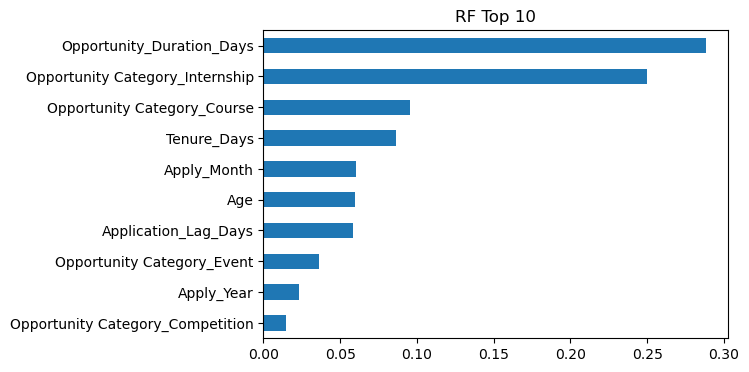

Top LogReg coefficients:
 Opportunity Category_Internship     3.656422
Apply_Year                         -3.375475
Application_Lag_Days                3.239679
Tenure_Days                        -3.045368
Apply_Month                        -2.081275
Opportunity_Duration_Days          -2.056888
Opportunity Category_Event         -1.864619
Opportunity Category_Competition   -1.481938
Opportunity Category_Course        -0.836418
Gender_Female                      -0.610859
Gender_Male                        -0.595221
Region_Africa                      -0.538801
Opportunity Category_Engagement    -0.327504
Gender_Don'T Want To Specify        0.196632
Region_Asia                        -0.195371
dtype: float64


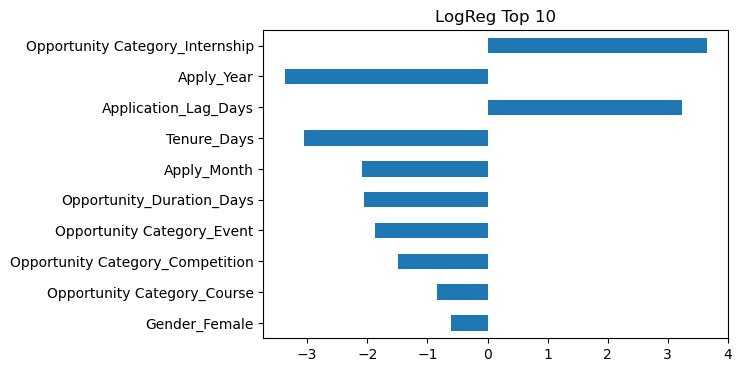

In [12]:
# feature importance (RF) and coefficients (LogReg)

# helper to get feature names after preprocessing
def get_feature_names(preproc, numeric_feats, cat_feats):
    num_names = numeric_feats
    cat_names = []
    if len(cat_feats) > 0:
        ohe = preproc.named_transformers_['cat'].named_steps['onehot']
        cat_names = list(ohe.get_feature_names_out(cat_feats))
    return list(num_names) + cat_names

# Random Forest feature importance
rf_preproc = rf_pipe.named_steps['preproc']
rf_features = get_feature_names(rf_preproc, numeric_feats, cat_feats)
rf_importances = rf_pipe.named_steps['clf'].feature_importances_
rf_fi = pd.Series(rf_importances, index=rf_features).sort_values(ascending=False)
print("Top RF features:\n", rf_fi.head(15))
plt.figure(figsize=(6,4)); rf_fi.head(10).plot(kind='barh'); plt.gca().invert_yaxis(); plt.title('RF Top 10'); plt.show()

# Logistic Regression coefficients (magnitude)
log_preproc = log_pipe.named_steps['preproc']
log_features = get_feature_names(log_preproc, numeric_feats, cat_feats)
log_coefs = log_pipe.named_steps['clf'].coef_[0]
log_ser = pd.Series(log_coefs, index=log_features).sort_values(key=lambda s: s.abs(), ascending=False)
print("Top LogReg coefficients:\n", log_ser.head(15))
plt.figure(figsize=(6,4)); log_ser.head(10).plot(kind='barh'); plt.gca().invert_yaxis(); plt.title('LogReg Top 10'); plt.show()


In [13]:
# save metrics and key outputs to /mnt/data/model_outputs
outdir = "/mnt/data/model_outputs"
os.makedirs(outdir, exist_ok=True)

pd.DataFrame([metrics_log, metrics_rf], index=['LogReg','RandomForest']).T.to_csv(os.path.join(outdir,"model_performance_summary.csv"))
rf_fi.to_csv(os.path.join(outdir,"rf_feature_importance.csv"))
log_ser.to_csv(os.path.join(outdir,"logreg_coefficients.csv"))
print("Saved model outputs to", outdir)


Saved model outputs to /mnt/data/model_outputs


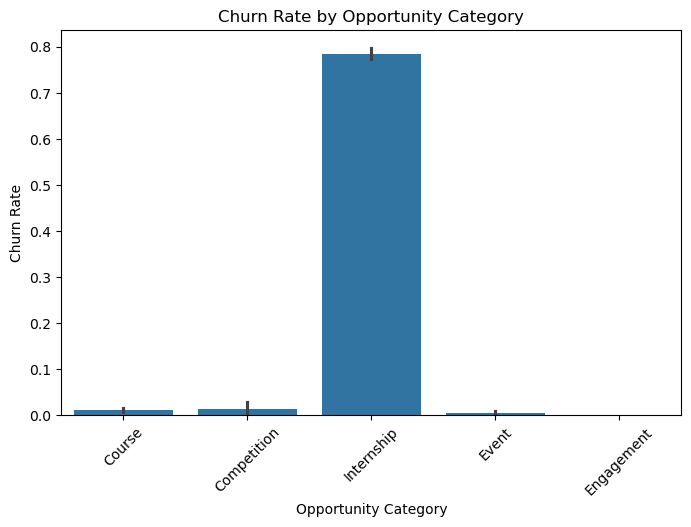

In [14]:
#Internship Opportunity

plt.figure(figsize=(8,5))
sns.barplot(x="Opportunity Category", y="churn", data=df_e, estimator=lambda x: sum(x)/len(x))
plt.title("Churn Rate by Opportunity Category")
plt.ylabel("Churn Rate")
plt.xlabel("Opportunity Category")
plt.xticks(rotation=45)
plt.show()


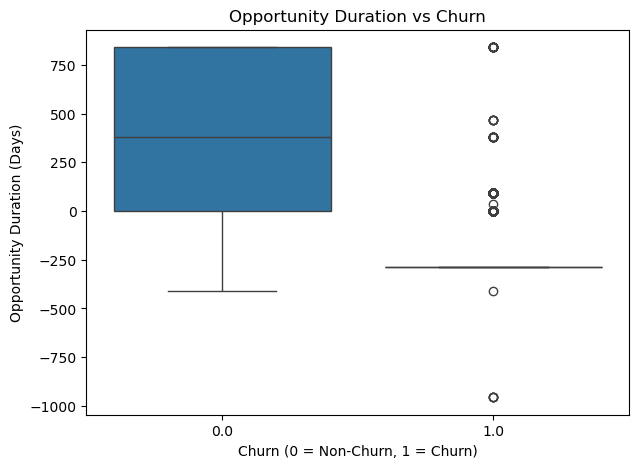

In [22]:
#Opportunity Duration

plt.figure(figsize=(7,5))
sns.boxplot(x="churn", y="Opportunity_Duration_Days", data=df_e)
plt.title("Opportunity Duration vs Churn")
plt.xlabel("Churn (0 = Non-Churn, 1 = Churn)")
plt.ylabel("Opportunity Duration (Days)")
plt.show()


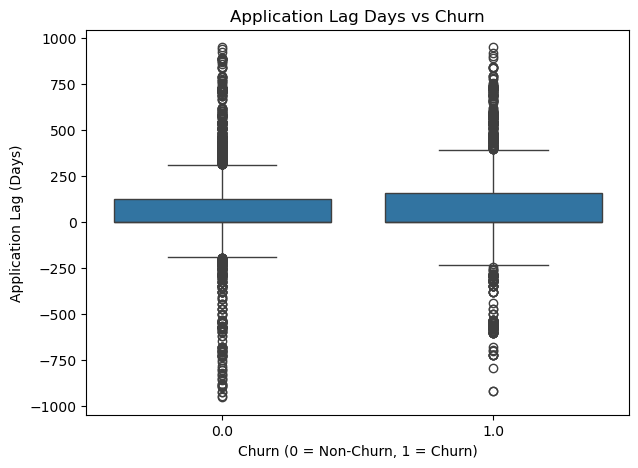

In [18]:
#Application Lag

plt.figure(figsize=(7,5))
sns.boxplot(x="churn", y="Application_Lag_Days", data=df_e)
plt.title("Application Lag Days vs Churn")
plt.xlabel("Churn (0 = Non-Churn, 1 = Churn)")
plt.ylabel("Application Lag (Days)")
plt.show()


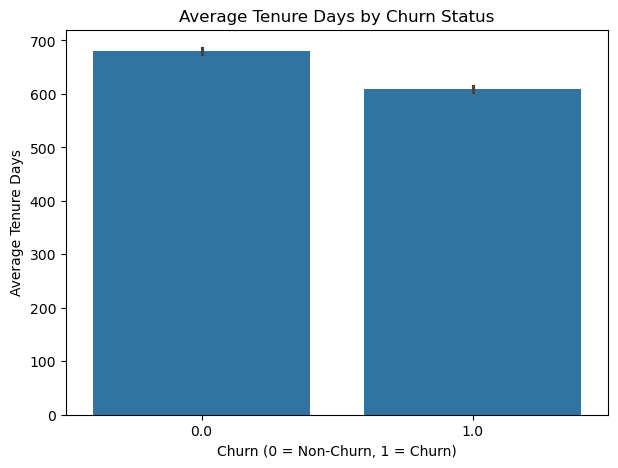

In [19]:


plt.figure(figsize=(7,5))
sns.barplot(x="churn", y="Tenure_Days", data=df_e, estimator=lambda x: sum(x)/len(x))
plt.title("Average Tenure Days by Churn Status")
plt.xlabel("Churn (0 = Non-Churn, 1 = Churn)")
plt.ylabel("Average Tenure Days")
plt.show()


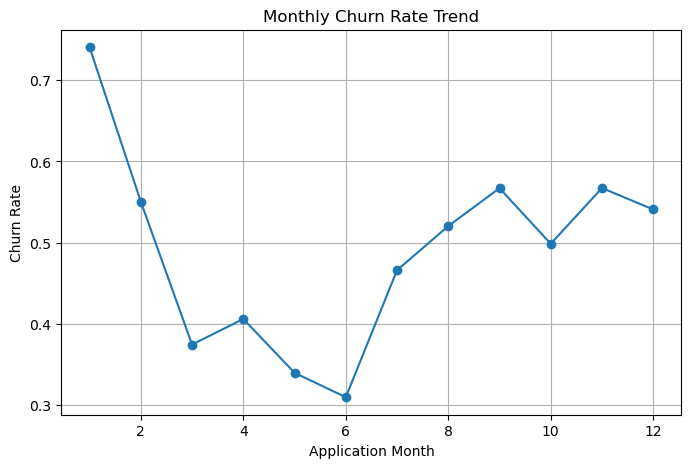

In [20]:
# Extract application month if not already created
df_e['Apply_Month'] = pd.to_datetime(df_e['Learner SignUp DateTime']).dt.month

monthly_churn = df_e.groupby('Apply_Month')['churn'].mean()

plt.figure(figsize=(8,5))
monthly_churn.plot(kind='line', marker='o')
plt.title("Monthly Churn Rate Trend")
plt.xlabel("Application Month")
plt.ylabel("Churn Rate")
plt.grid(True)
plt.show()


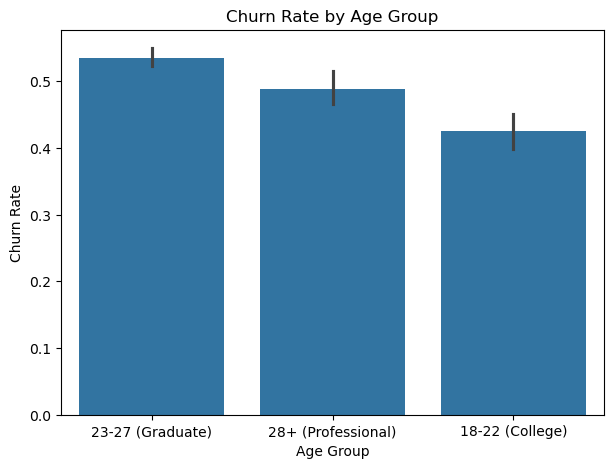

In [26]:


# Define age groups

plt.figure(figsize=(7,5))
sns.barplot(x="Age_Group", y="churn", data=df_e, estimator=lambda x: sum(x)/len(x))
plt.title("Churn Rate by Age Group")
plt.ylabel("Churn Rate")
plt.xlabel("Age Group")
plt.show()
